In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import rioxarray as rio
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import math
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.patches as patches

In [2]:
def match_crs(vector,raster):
    vector = vector.to_crs(raster.rio.crs)
    return vector

In [3]:
def clip_raster(raster,vector):
    vector = vector.to_crs(raster.rio.crs)
    geom = vector.geometry
    raster_clipped = raster.rio.clip(geom, from_disk = True)
    return raster_clipped

In [4]:
def plotter(rp, op, ip, dam, path_data, path_results, nuts3, osmsites, sectors, substations, ax):
    # Results
    floodmap = rio.open_rasterio(os.path.join(path_data,f'rotterdam_event_RP{rp}.tif'))
    ci_df = pd.read_excel(os.path.join(path_results, f'ci_{op}_{ip}_mosek_{rp}_{dam}.xlsx'), index_col = [0])
    os_df = pd.read_excel(os.path.join(path_results, f'osm_industrial_{op}_{ip}_mosek_{rp}_{dam}.xlsx'), index_col = [0])

    # Assigning damage to geo dataframe
    osmsites['flood_fail'] = os_df['flood_fail']
    osmsites['power_fail'] = os_df['power_fail']
    substations['flood_fail'] = ci_df['flood_fail']

    sectors_centroids = sectors.copy()
    sectors_centroids['geometry'] = sectors_centroids.geometry.centroid

    sectors_in_osmsite = gpd.sjoin(
    sectors_centroids,
    osmsites[['geometry', 'osmid', 'flood_fail', 'power_fail']],
    how='inner',
    predicate='within'
    )

    sectors_in_osmsite = sectors_in_osmsite.reset_index(drop=True)
    substations_centroids = substations.copy()
    substations_centroids['geometry'] = substations_centroids.geometry.centroid

    nuts3 = match_crs(nuts3,floodmap)
    nuts_of_interest = ['NL33C']
    nuts_of_interest_df  = nuts3[nuts3['NUTS_ID'].isin(nuts_of_interest)]

    floodmap_clipped = clip_raster(floodmap,nuts_of_interest_df)

    # 1. Ensure same CRS
    nuts_of_interest_df = nuts_of_interest_df.to_crs(floodmap_clipped.rio.crs)
    
    # 2. Extract the geometries as a list of shapely geometries
    geometries = nuts_of_interest_df.geometry.values
    
    # 3. Clip the raster by the polygon geometry
    raster_clipped_exact = floodmap_clipped.rio.clip(geometries, nuts_of_interest_df.crs, drop=True, invert=False)


    
    nuts_of_interest_df = nuts_of_interest_df.to_crs(floodmap_clipped.rio.crs)
    raster_data = raster_clipped_exact.values.squeeze()
    raster_masked = np.ma.masked_where(np.isnan(raster_data), raster_data)
    
    xmin, ymin, xmax, ymax = (
        floodmap_clipped.x.min().item(),
        floodmap_clipped.y.min().item(),
        floodmap_clipped.x.max().item(),
        floodmap_clipped.y.max().item()
    )
    

    ax.imshow(raster_masked, extent=[xmin, xmax, ymin, ymax], cmap='Blues')
    ax.set_axis_off()
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    
    # Plotting Zuid Holland
    nuts3 = match_crs(nuts3,floodmap)
    nuts3.plot(ax=ax, color='GREY', alpha=0.5)
    
    # Plotting all the firms
    sectors_in_osmsite = match_crs(sectors_in_osmsite,floodmap)
    sectors_in_osmsite.plot(ax=ax, color='#a99985', markersize = 0.3)
    
    # Plotting all the substations
    substations_centroids = match_crs(substations_centroids,floodmap)
    # substations_centroids.plot(ax=ax, color='pink', markersize = 20,  marker='o' )
    
    ## Plotting power failed firsm
    sectors_in_osmsite_power = sectors_in_osmsite[sectors_in_osmsite['power_fail'] == 0]
    sectors_in_osmsite_power.plot(ax=ax, color='red', markersize = 2)
    
    ## Plotting flooded firsm
    sectors_in_osmsite_flood = sectors_in_osmsite[sectors_in_osmsite['flood_fail'] == 0]
    sectors_in_osmsite_flood.plot(ax=ax, color='blue', markersize = 2)
    
    # Plotting fialed substations
    substations_centroids_failed = substations_centroids[substations_centroids['flood_fail'] == 0]
    substations_centroids_failed.plot(ax=ax, color='black', markersize = 20,  marker='x' )

In [5]:
def expected_annual_impact_calculation(op1, if1, cif, RP, k):

    total_cost_results = pd.DataFrame()
    for i in range(len(RP)):

            rp = RP[i]
            ci_f = cif
            op_factor = op1
            imp_flex  = if1
            path = os.path.join(os.path.dirname(os.getcwd()), 'results')
            
            # Rationing corrected output loss
            Xbase = pd.read_excel(os.path.join(path, f'Xbase_{op_factor}_{imp_flex}_mosek_{ci_f}_{rp}_{k}.xlsx'), index_col = [0], header = [1])
            Xbase = Xbase.drop("Index2", axis = 'index')
            Xbase_sum = Xbase.sum().sum()
            
            X1 = pd.read_excel(os.path.join(path, f'Xdis3_{op_factor}_{imp_flex}_mosek_{ci_f}_{rp}_{k}.xlsx'), index_col = [0], header = [1])
            X1 = X1.drop("Index2", axis = 'index')
            X1_sum = X1.sum().sum()
            
            rat = pd.read_excel(os.path.join(path, f'Rat_{op_factor}_{imp_flex}_mosek_{ci_f}_{rp}_{k}.xlsx'), index_col = [0], header = [0,1])
            rat_sum = rat.sum().sum()
            
            c3 = (Xbase_sum - X1_sum) - rat_sum
            
            
            # Actual inefficiency
            ineff1 = pd.read_excel(os.path.join(path, f'ineff3_{op_factor}_{imp_flex}_mosek_{ci_f}_{rp}_{k}.xlsx'), index_col = [0], header = [1])
            ineff1 = ineff1.drop("Index2", axis = 'index')
            ineff1 = ineff1.sum().sum()
            
            c2 = ineff1
            
            # Production equivalent of ratioing
            X2 = pd.read_excel(os.path.join(path, f'Xdis5_{op_factor}_{imp_flex}__mosek_{ci_f}_{rp}_{k}.xlsx'), index_col = [0], header = [1])
            X2 = X2.drop("Index2", axis = 'index')
            X2_sum = X2.sum().sum()
            c1 = X2_sum 

            cost = (c1 + c2+ c3 ) / 365
            total_cost_results.loc[rp, 'cost_per_day'] = cost

    recovery_duration = []
    no_of_flooded = []

    for i in range(len(RP)):
        rp = RP[i]
        path = os.path.join(os.path.dirname(os.getcwd()), 'results')
        osm = pd.read_excel(os.path.join(path, f'osm_industrial_{op_factor}_{imp_flex}_mosek_{rp}_{k}.xlsx'), index_col = [0], header = [0])
        osm_failed = osm[osm['flood_fail'] == 0]
        osm_failed['duration'] = (osm_failed['depth'] * 16.6) + 7.738  # From T. Endendijk et al.(2024)
        recovery_duration.append(osm_failed['duration'].mean())
        no_of_flooded.append(len(osm_failed))

    no_of_flooded_log = [math.log10(x+1) for x in no_of_flooded]
    total_cost_results['cost'] = total_cost_results['cost_per_day'] * recovery_duration * no_of_flooded_log
    return total_cost_results

In [6]:
def production_shock_plotter(df, ax):
    x_pos = np.arange(len(df))
    width = 0.3
    colors = ['#b0c4b1', '#1d3557']
    hatches = ['//', '//']

    for i in range(len(RP)):
        rp = RP[i]
        wo_ci_col = f'wo_ci_{rp}'
        wi_ci_col = f'wi_ci_{rp}'
        
        # Position for each bar in group
        bar_positions = x_pos + i * width
        
        # Bar heights
        wo_heights = df[wo_ci_col]
        diff_heights = df[wi_ci_col] - df[wo_ci_col]
        total_heights = df[wi_ci_col]
    
        # Plot bars
        bars1 = ax.bar(bar_positions, wo_heights, width, color=colors[i])
        bars2 = ax.bar(bar_positions, diff_heights, width, bottom=wo_heights, color=colors[i], hatch=hatches[i], alpha=0.5)
    
        
        # Add annotations
        for j, pos in enumerate(bar_positions):
            label_col = f'%inc_{rp}'  
            label_value = df[label_col].iloc[j]
            ax.text(pos, total_heights.iloc[j] + 0.5,  # 1 unit above bar
                    f'{label_value:.0f}%', ha='center', va='bottom', fontsize=8, fontname='Calibri', color='red')
    
    legend_elements = [
        mpatches.Patch(facecolor=colors[0], label='RP-1000'),  # Solid color for RP1000
        mpatches.Patch(facecolor=colors[1], label='RP-10000'), # Solid color for RP10000
        mpatches.Patch(facecolor='white', hatch='//', edgecolor='black', label='Additional shock due to CI disruption')  # Hatch only
    ]
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1),
              ncol=3, frameon=False, fontsize=10, prop={'family': 'Calibri'})
    
    
    # Center x-ticks between grouped bars
    group_centers = x_pos + width / 2
    ax.set_xticks(group_centers)
    ax.set_xticklabels(df['sector'], rotation=0, ha='center', fontname='Calibri', fontsize=10)
    
    # Y-axis formatting
    ax.set_yticks(np.arange(0, 35, 5))
    ax.set_yticklabels(np.arange(0, 35, 5), fontname='Calibri', fontsize=10)
    ax.set_ylabel("Production shock (%)", fontname='Calibri', fontsize=10)
    ax.set_xlabel("Sector", fontname='Calibri', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

C:\Users\sva100\AppData\Local\Temp\ipykernel_10628\3578393412.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sectors_centroids['geometry'] = sectors_centroids.geometry.centroid
C:\Users\sva100\AppData\Local\Temp\ipykernel_10628\3578393412.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  substations_centroids['geometry'] = substations_centroids.geometry.centroid
C:\Users\sva100\AppData\Local\Temp\ipykernel_10628\3578393412.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sectors_centroids['geometry'] = sectors_centroids.geometry.centroid
C:\Users\sva100\AppD

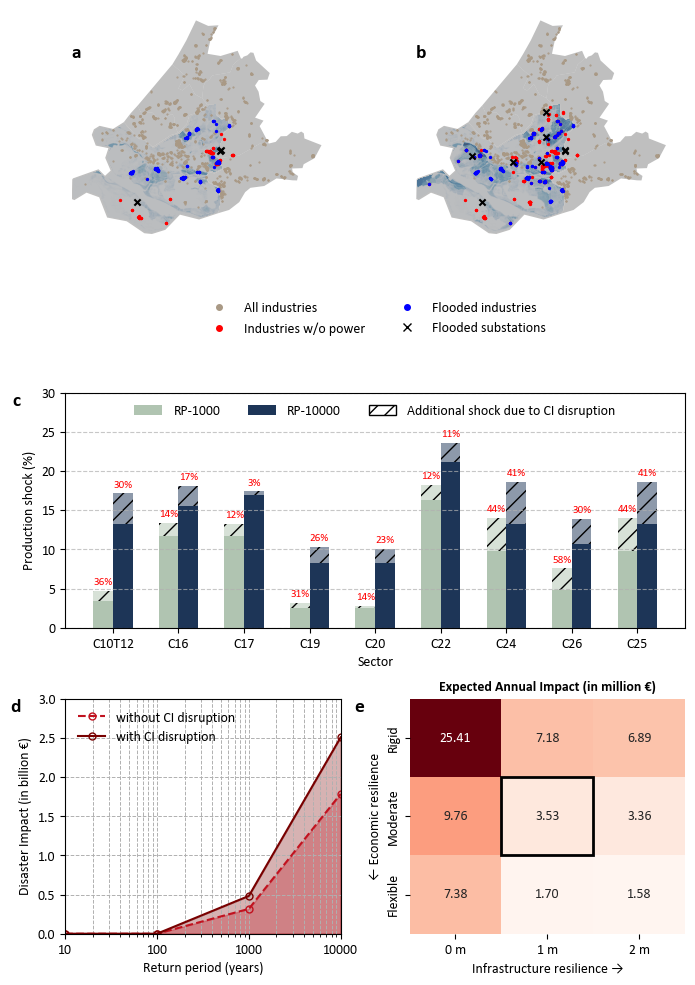

In [12]:
fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(4, 2, height_ratios=[1,0.025, 1, 1], figure=fig, hspace = 0.4, wspace=0.25)

text_x = -0.2
text_y = 1


# Plot 1
ax0 = fig.add_subplot(gs[0, 0])
path_data = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data')
path_results = os.path.join(os.path.dirname(os.getcwd()), 'results')

# Inputs
osmsites = gpd.read_parquet(os.path.join(path_data, 'is_nl33.parquet'))
sectors = gpd.read_parquet(os.path.join(path_data, 'industrial.parquet'))
substations = gpd.read_parquet(os.path.join(path_data,'substaions_nl33.parquet'))
nuts3 = gpd.read_file(os.path.join(path_data,'NUTS3_Zuid_Holland.shp'))

op = 1.01
ip = 0.25
dam = 2
RP = [1000, 10000]
cif = 'ci'

plotter(RP[0], op, ip, dam, path_data, path_results, nuts3, osmsites, sectors, substations, ax=ax0)
ax0.text(text_x*0, text_y*0.85, 'a', transform=ax0.transAxes, fontsize=14, fontweight='bold', va='top', ha='left',  fontname='Calibri')

ax1 = fig.add_subplot(gs[0, 1])
plotter(RP[1], op, ip, dam, path_data, path_results, nuts3, osmsites, sectors, substations, ax=ax1)
ax1.text(text_x*0, text_y*0.85, 'b', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left',  fontname='Calibri')


# Row 2 — Legend-style dummy plots
ax2 = fig.add_subplot(gs[1, :])
legend_elements = [ mlines.Line2D([], [], color='#a99985', marker='o', linestyle='None', markersize=4, label='All industries'), mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=4, label='Industries w/o power'),
                    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=4, label='Flooded industries'), mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=6, label='Flooded substations')]


ax2.legend(handles=legend_elements, loc='center', ncol=2, frameon=False, prop={'family': 'calibri', 'size': 10})
ax2.axis('off')


# Row 2 — bar charts
ax4 = fig.add_subplot(gs[2, :])
path = os.path.join(os.path.dirname(os.getcwd()), 'results')
RP = [1000, 10000]
op = 1.01
ip = 0.25
dam = 2
prod_results = pd.DataFrame()
for i in range(len(RP)):
    rp = RP[i]
    filename = f'prod_df_{op}_{ip}_mosek_{rp}_{dam}.xlsx'
    filepath = os.path.join(path, filename)
    prod = pd.read_excel(filepath, index_col = [0])
    prod['wo_ci'] = (1 - prod['wo_ci'])*100
    prod['wi_ci'] = (1 - prod['wi_ci'])*100
    prod_results['sector'] =  prod['sector']
    prod_results[f'wo_ci_{rp}'] = prod['wo_ci']
    prod_results[f'wi_ci_{rp}'] = prod['wi_ci']

for i in range(len(RP)):
    rp = RP[i]
    prod_results[f'%inc_{rp}'] = ((prod_results[f'wi_ci_{rp}'] - prod_results[f'wo_ci_{rp}']) / prod_results[f'wo_ci_{rp}'])*100

production_shock_plotter(prod_results, ax4)
ax4.text(-0.085, text_y, 'c', transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top', ha='left',  fontname='Calibri')

# Row 3 — line + heatmap
ax5 = fig.add_subplot(gs[3, 0])
# Define Overproduction and Flex parameters
RP = [10,100,1000,10000]
font = 'Calibri'
c11 = '#780000'
c21 = '#c1121f'
c31 = '#22577a'
size_font = 10

total_cost_results_ci = expected_annual_impact_calculation(1.01, 0.25, 'ci', RP, 2)
total_cost_results_noci = expected_annual_impact_calculation(1.01, 0.25, 'noci', RP, 2)

ax5.plot(total_cost_results_noci.index, total_cost_results_noci['cost']/1000, markersize =5, c = c21, linewidth = 1.5, marker = 'o', markerfacecolor='none', linestyle='--', label = 'without CI disruption')
ax5.plot(total_cost_results_ci.index, total_cost_results_ci['cost']/1000, markersize =5, c = c11, linewidth = 1.5, marker = 'o', markerfacecolor='none', linestyle='-' , label = 'with CI disruption')

ax5.fill_between(total_cost_results_ci.index, total_cost_results_ci['cost']/1000, color=c11, alpha=0.3)
ax5.fill_between(total_cost_results_noci.index, total_cost_results_noci['cost']/1000, color=c21, alpha=0.3)
ax5.set_xlim([10,10000])
ax5.set_ylim([0,3])
ax5.set_xscale('log')
ax5.set_xticks(total_cost_results_ci.index)
ax5.set_xticklabels(total_cost_results_ci.index, fontsize=10, fontname=font)
ax5.set_yticks(ax5.get_yticks())
ax5.set_yticklabels(ax5.get_yticks(), fontsize=10, fontname=font)
ax5.grid(True, which='both', linestyle='--', linewidth=0.7)
ax5.set_xlabel('Return period (years)', fontsize=size_font, fontname=font)
ax5.set_ylabel('Disaster Impact (in billion €)', fontsize=size_font, fontname=font)
ax5.legend(loc='upper left', prop={'family': font, 'size': size_font}, frameon=False)
ax5.text(text_x, text_y, 'd', transform=ax5.transAxes, fontsize=14, fontweight='bold', va='top', ha='left',  fontname='Calibri')


ax6 = fig.add_subplot(gs[3, 1])
path = os.path.dirname(os.getcwd())
data = pd.read_excel(os.path.join(path, 'eac_ci_df.xlsx'), index_col=0)

font = 'Calibri'
size_font = 10
cmap = 'Reds'
y_labels = ['Rigid', 'Moderate', 'Flexible']
x_labels = ['0 m', '1 m', '2 m']

sns.heatmap(
    data,
    ax=ax6,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    cbar=False,
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot_kws={"fontsize": size_font, "fontname": font}
)

rect = patches.Rectangle((1, 1), 1, 1, fill=False, edgecolor='black', linewidth=2)
ax6.add_patch(rect)
ax6.text(text_x, text_y, 'e', transform=ax6.transAxes, fontsize=14, fontweight='bold', va='top', ha='left',  fontname='Calibri')
ax6.set_xlabel('Infrastructure resilience →', fontsize=size_font, fontname=font)
ax6.set_ylabel('← Economic resilience', fontsize=size_font, fontname=font)
ax6.set_title('Expected Annual Impact (in million €)', fontsize=size_font, fontname=font, fontweight='bold')
ax6.set_xticklabels(x_labels, fontsize=size_font, fontname=font)
ax6.set_yticklabels(y_labels, fontsize=size_font, fontname=font, rotation=90)

plt.tight_layout()
plt.savefig('Figure1.png', dpi = 300, bbox_inches = 'tight')
plt.show()